In [ ]:
import wikipediaapi

import requests
import re

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display, HTML


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

import string
import time

import warnings
warnings.simplefilter("ignore")

# Data Scraping

In [67]:
wiki = wikipediaapi.Wikipedia(user_agent='DannyPham/0.0')
city_titles = ['New York City', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose']

In [68]:
def fetch_related_articles(city_title, max_articles=100):
    related_articles = []
    base_page = wiki.page(city_title)

    print(f"Fetching related articles from {base_page.title}")

    for count, (title, page) in enumerate(base_page.links.items()):
        if count >= max_articles:
            break
        if page.exists():
            article = {
                "title": title,
                "text": page.text
            }
            related_articles.append(article)

    return related_articles

In [69]:
city_dfs = [pd.DataFrame(fetch_related_articles(city)) for city in city_titles]

Fetching related articles from New York City
Fetching related articles from Los Angeles
Fetching related articles from Chicago
Fetching related articles from Houston
Fetching related articles from Phoenix
Fetching related articles from Philadelphia
Fetching related articles from San Antonio
Fetching related articles from San Diego
Fetching related articles from Dallas
Fetching related articles from San Jose


### A look at the New York City dataset

In [70]:
city_dfs[0].head()

,title,text
0,116 John Street,116 John Street is a historic office tower at ...
1,120 Wall Street,120 Wall Street is a skyscraper in the Financi...
2,125 Greenwich Street,125 Greenwich Street (also known as 22 Thames ...
3,130 Cedar Street,"130 Cedar Street, formerly known as the Green ..."
4,130 William,"130 William is an 800-foot-tall (240 m), resid..."


# Data Processing

In [71]:
def prepare_text(df):
    text = df.text.str.lower().reset_index().text
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = SnowballStemmer('english')
    eng_stopwords = [tokenizer.tokenize(s)[0] for s in stopwords.words('english')]

    def tokenize(text):
        tokens = tokenizer.tokenize(text)
        return [stemmer.stem(token) for token in tokens if token not in eng_stopwords]
    
    vectorizer = CountVectorizer(analyzer='word',
                                 tokenizer=tokenize,
                                 ngram_range=(0,1),
                                 strip_accents='unicode',
                                 max_df=0.1,
                                 min_df=0.0025)
    
    bag_of_words = vectorizer.fit_transform(text)
    features = vectorizer.get_feature_names_out()
    return bag_of_words, features

In [72]:
def apply_model(k, bag_of_words):
    lda = LatentDirichletAllocation(n_components=k,
                                    random_state=42,
                                    doc_topic_prior=1/k)
    lda.fit_transform(bag_of_words)
    return lda

In [98]:
def visualize_model(n_terms, features, lda, city_name):
    ls_keywords = []
    ls_freqs = []
    topic_id = []

    for i, topic in enumerate(lda.components_):
        word_idx = np.argsort(topic)[::-1][:n_terms]
        freqs = list(np.sort(topic)[::-1][:n_terms])
        keywords = [features[i] for i in word_idx]
        
        ls_keywords = ls_keywords + keywords
        ls_freqs = ls_freqs + freqs
        topic_id = topic_id + [i+1] * n_terms


    top_words_df = pd.DataFrame({'keywords':ls_keywords, 'frequency':ls_freqs, 'topic_id':topic_id})
    sns.catplot(top_words_df, x = 'frequency', y = 'keywords', col = 'topic_id', kind = 'bar', sharey = False, col_wrap=4, palette='flare', hue='topic_id')
    plt.subplots_adjust(top=0.9)
    plt.suptitle(city_name, fontsize=28, y=0.95)
    plt.show()

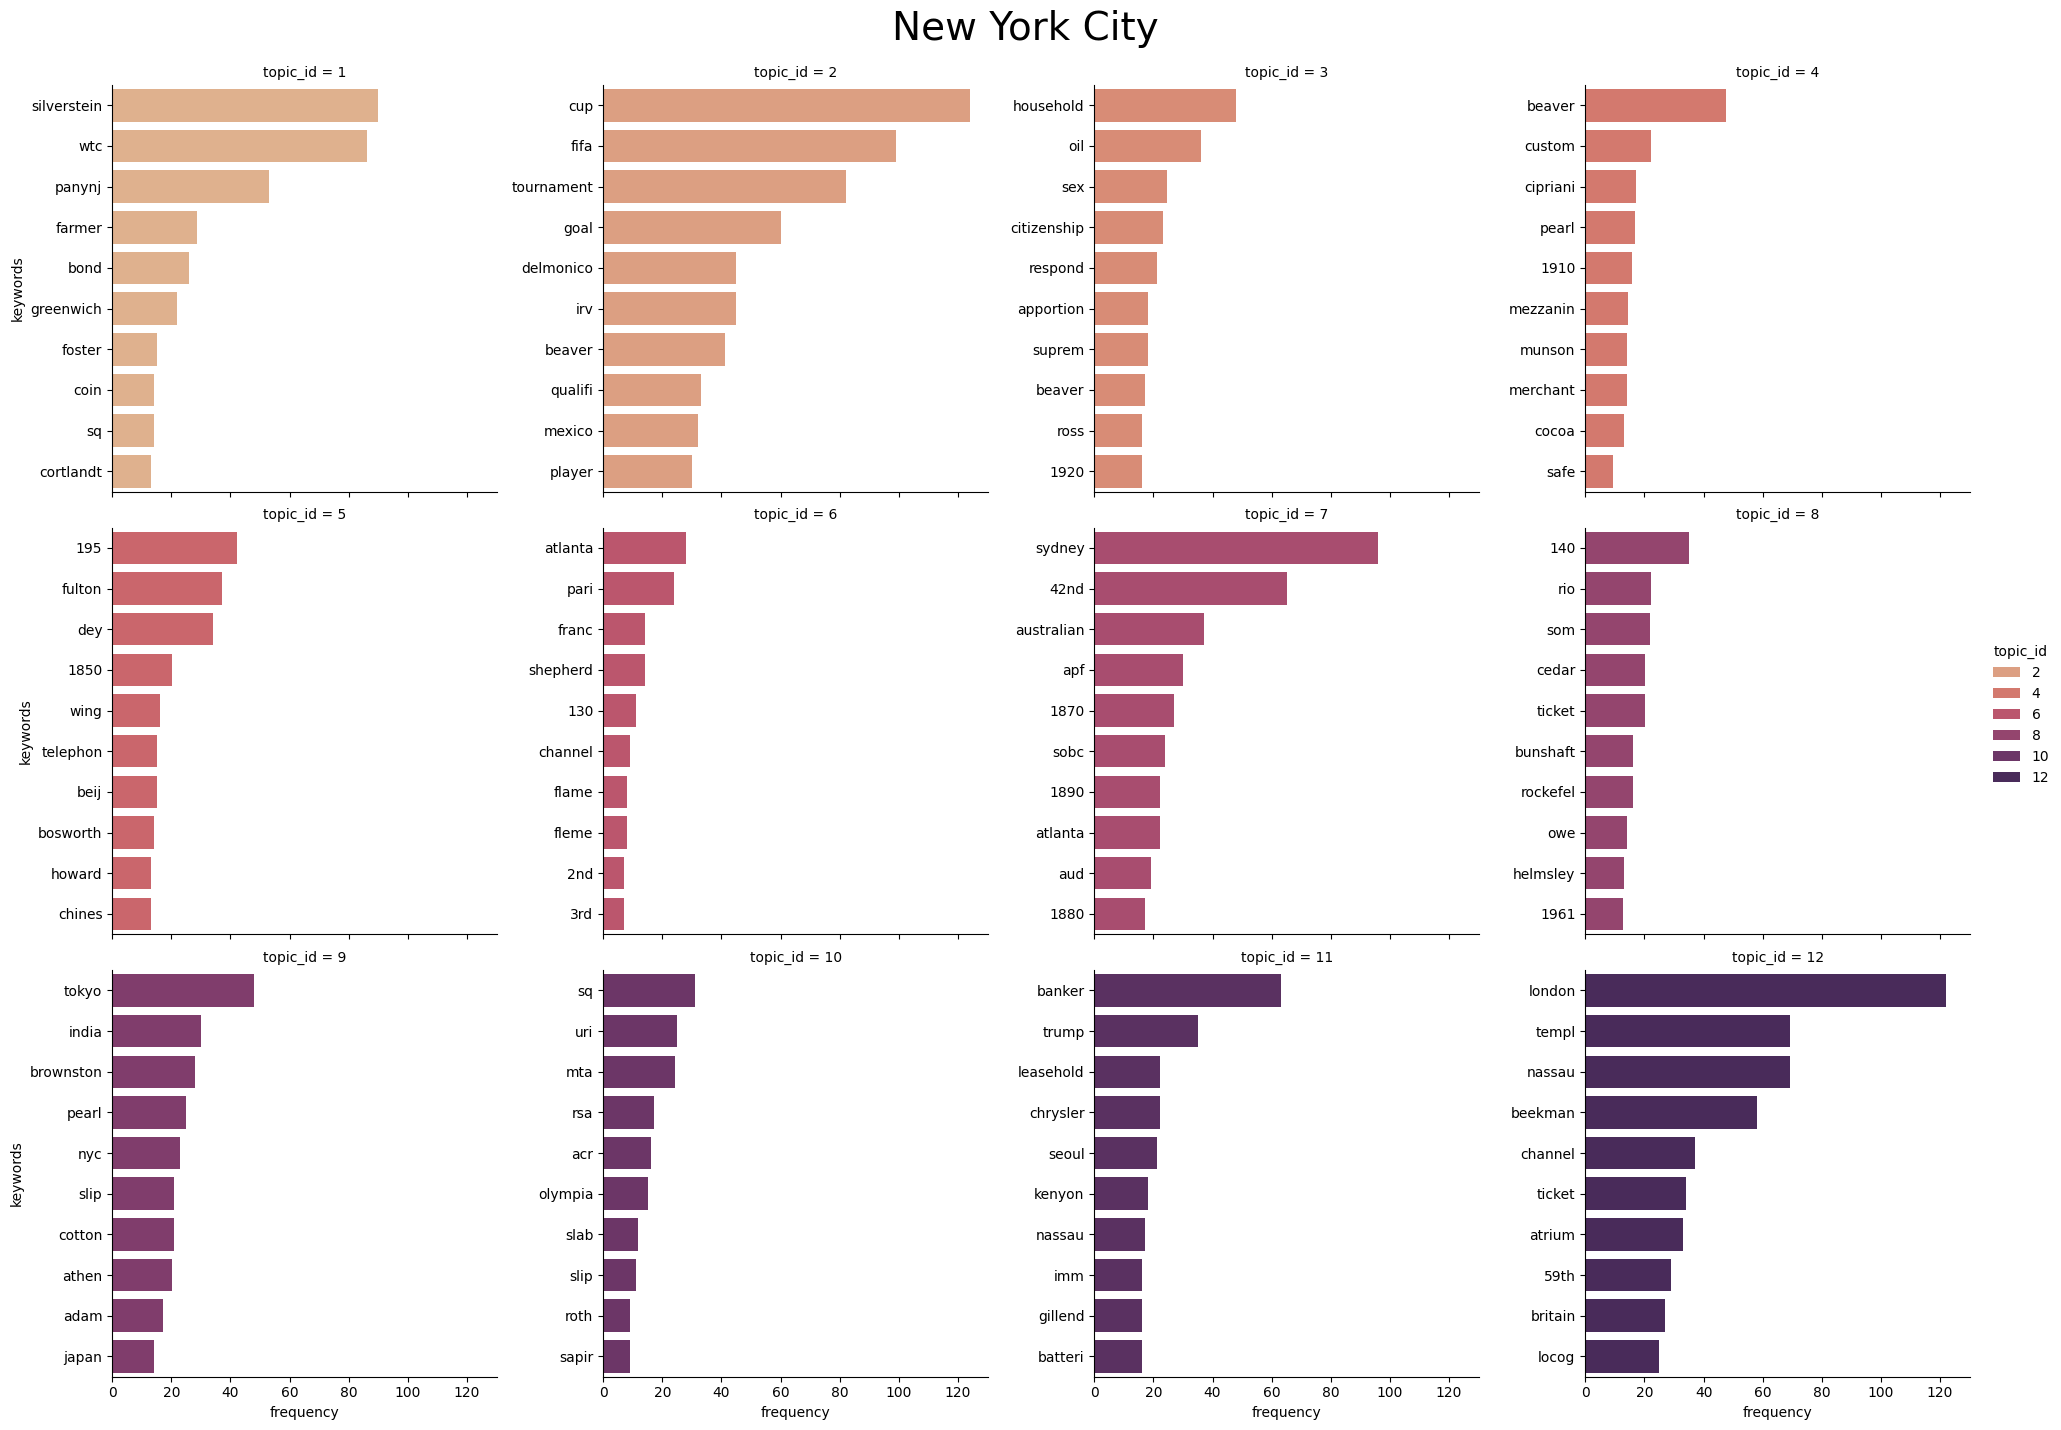

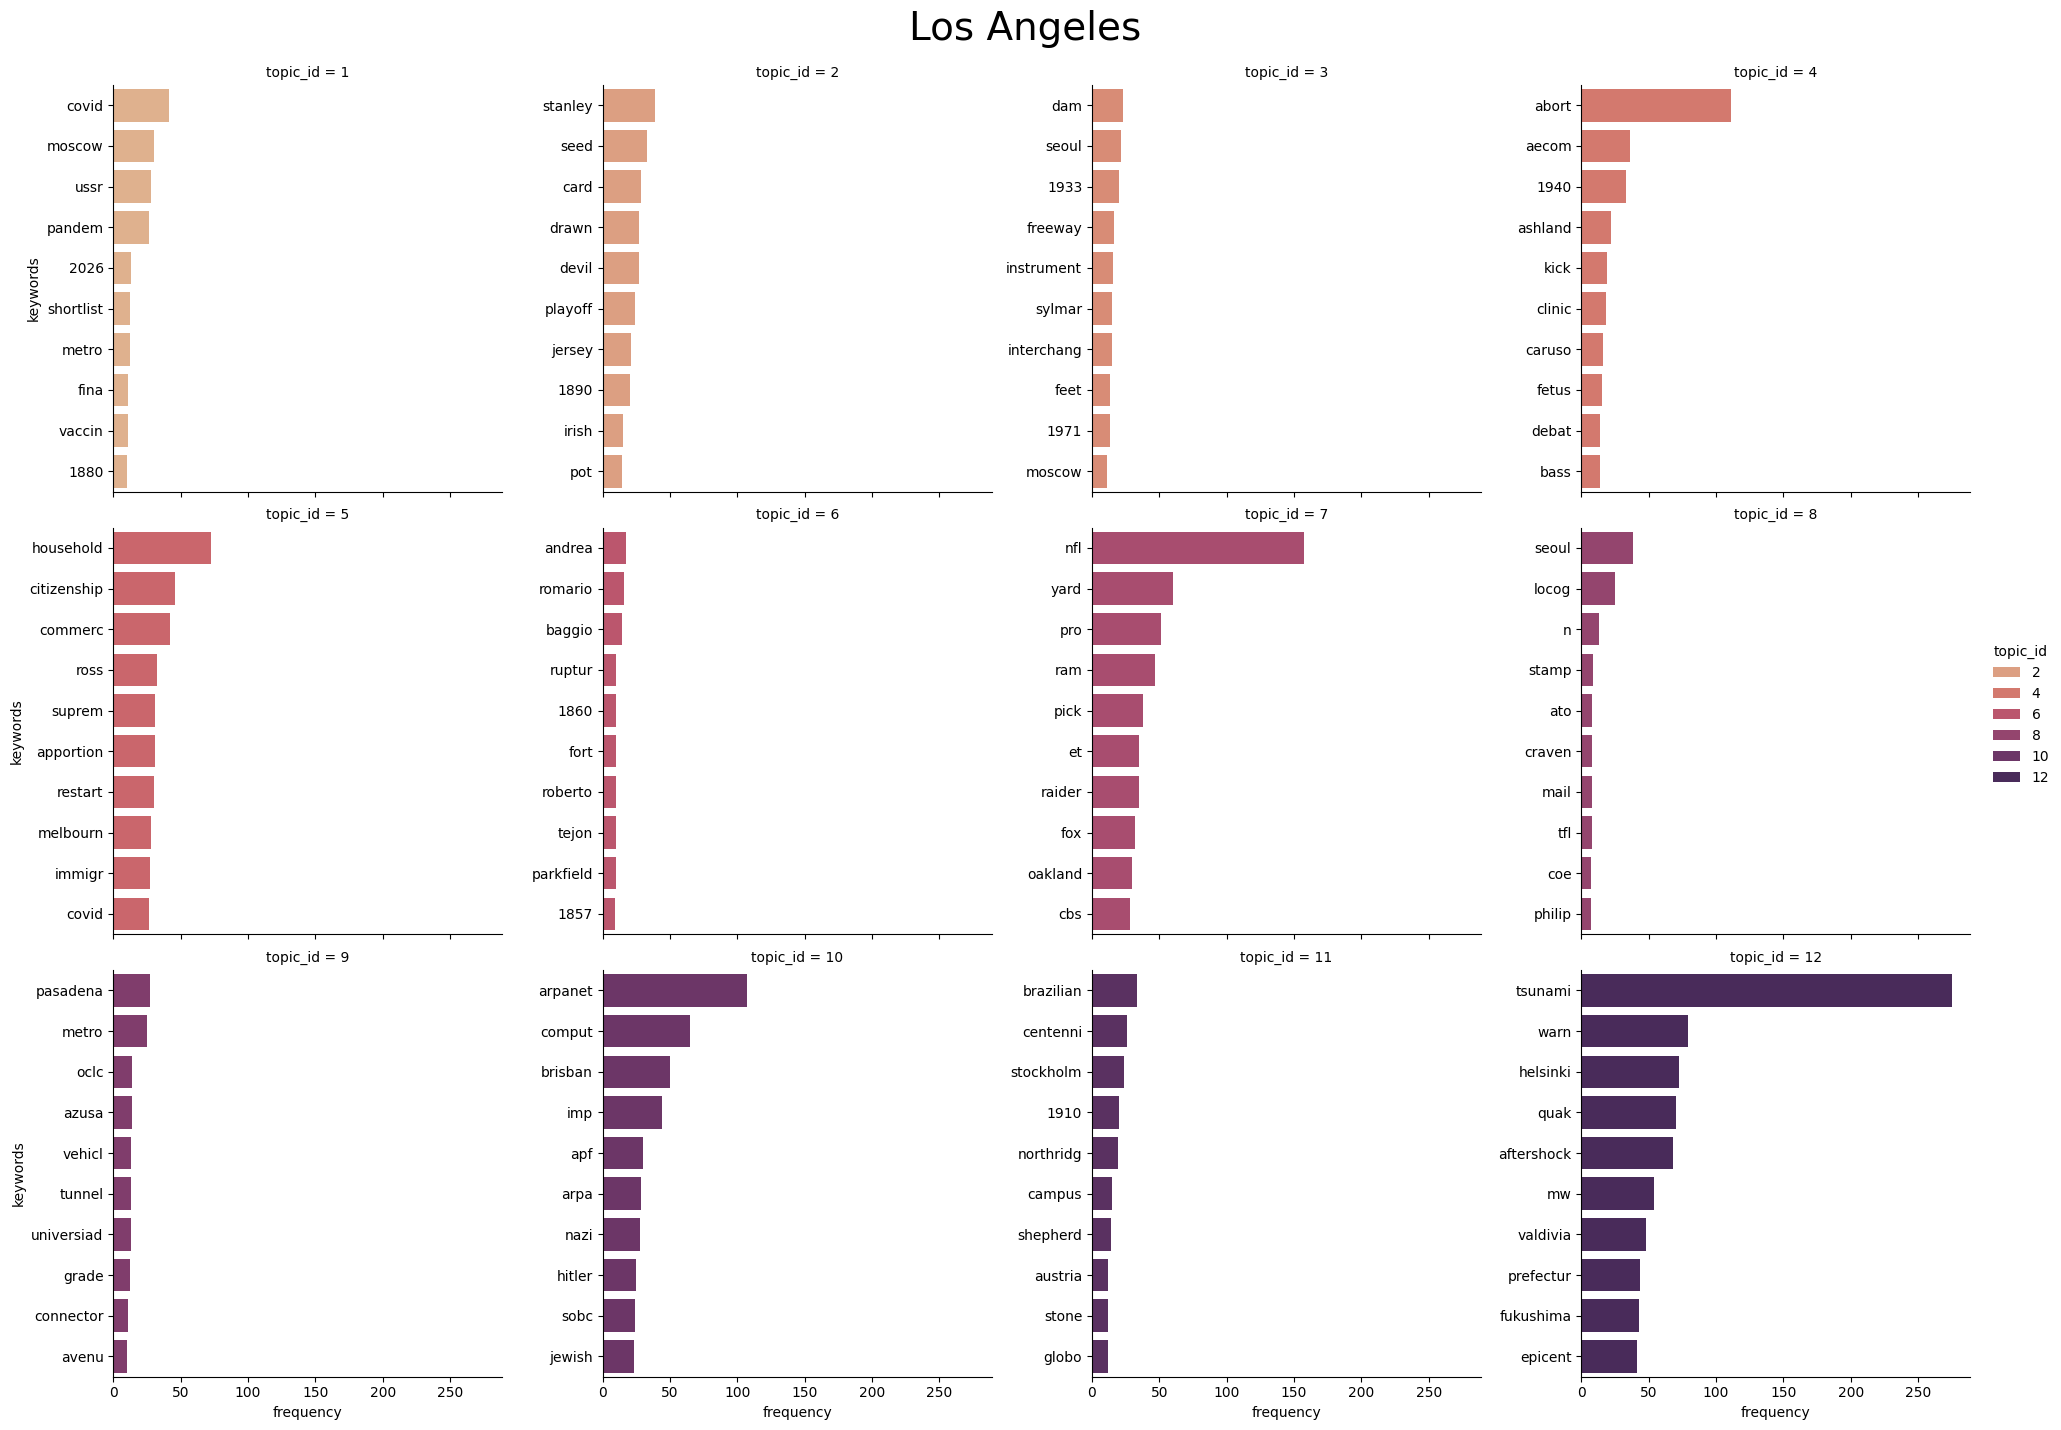

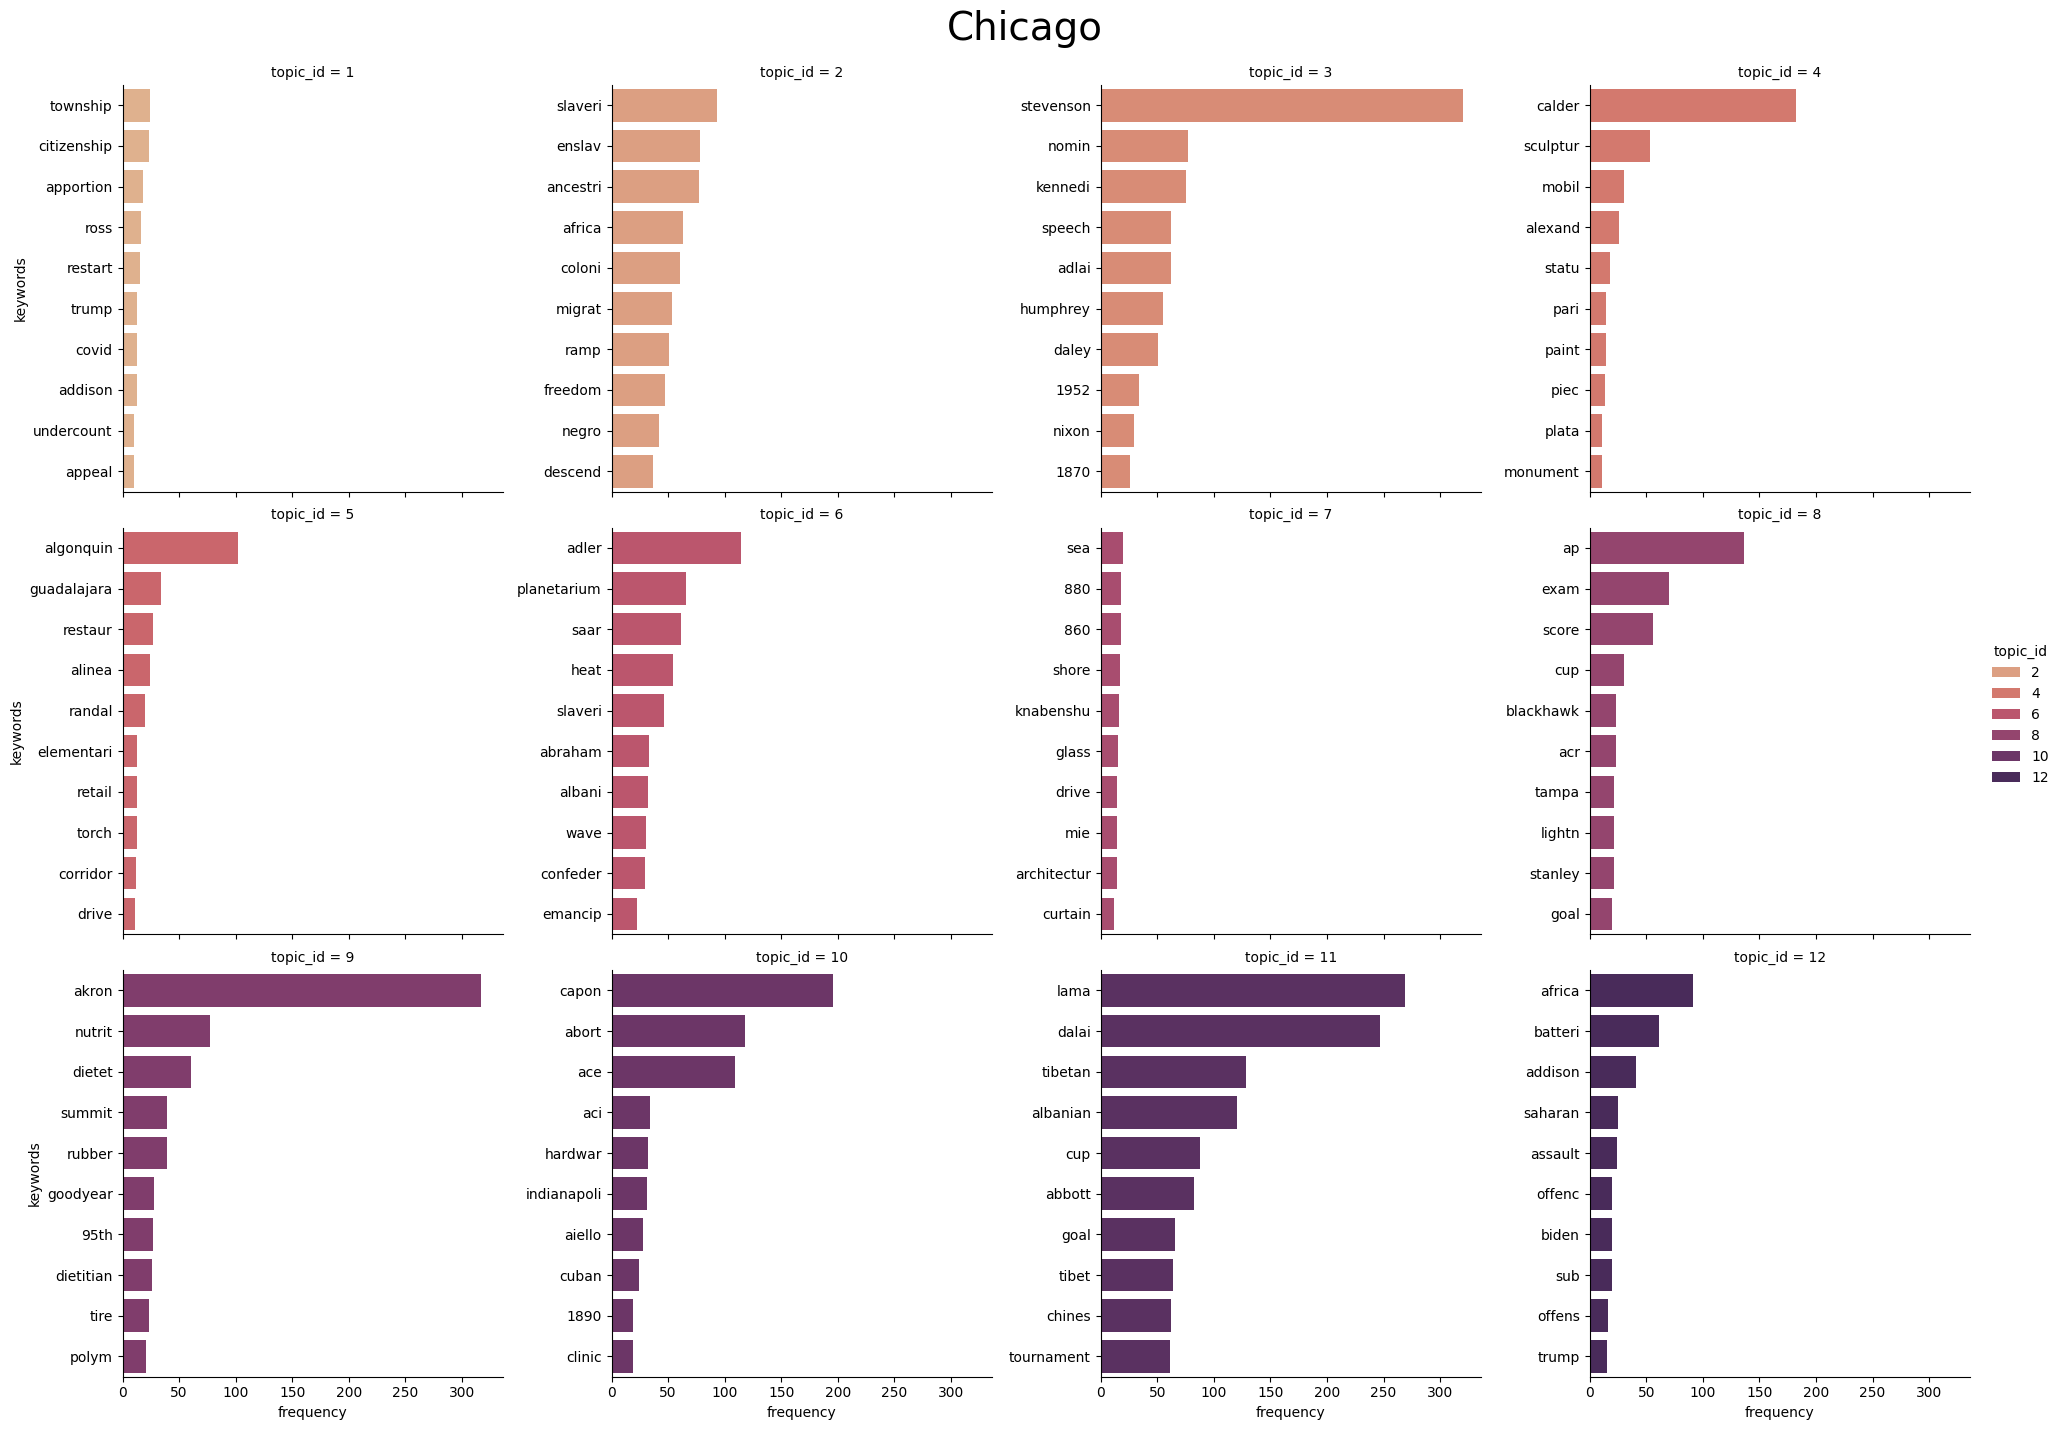

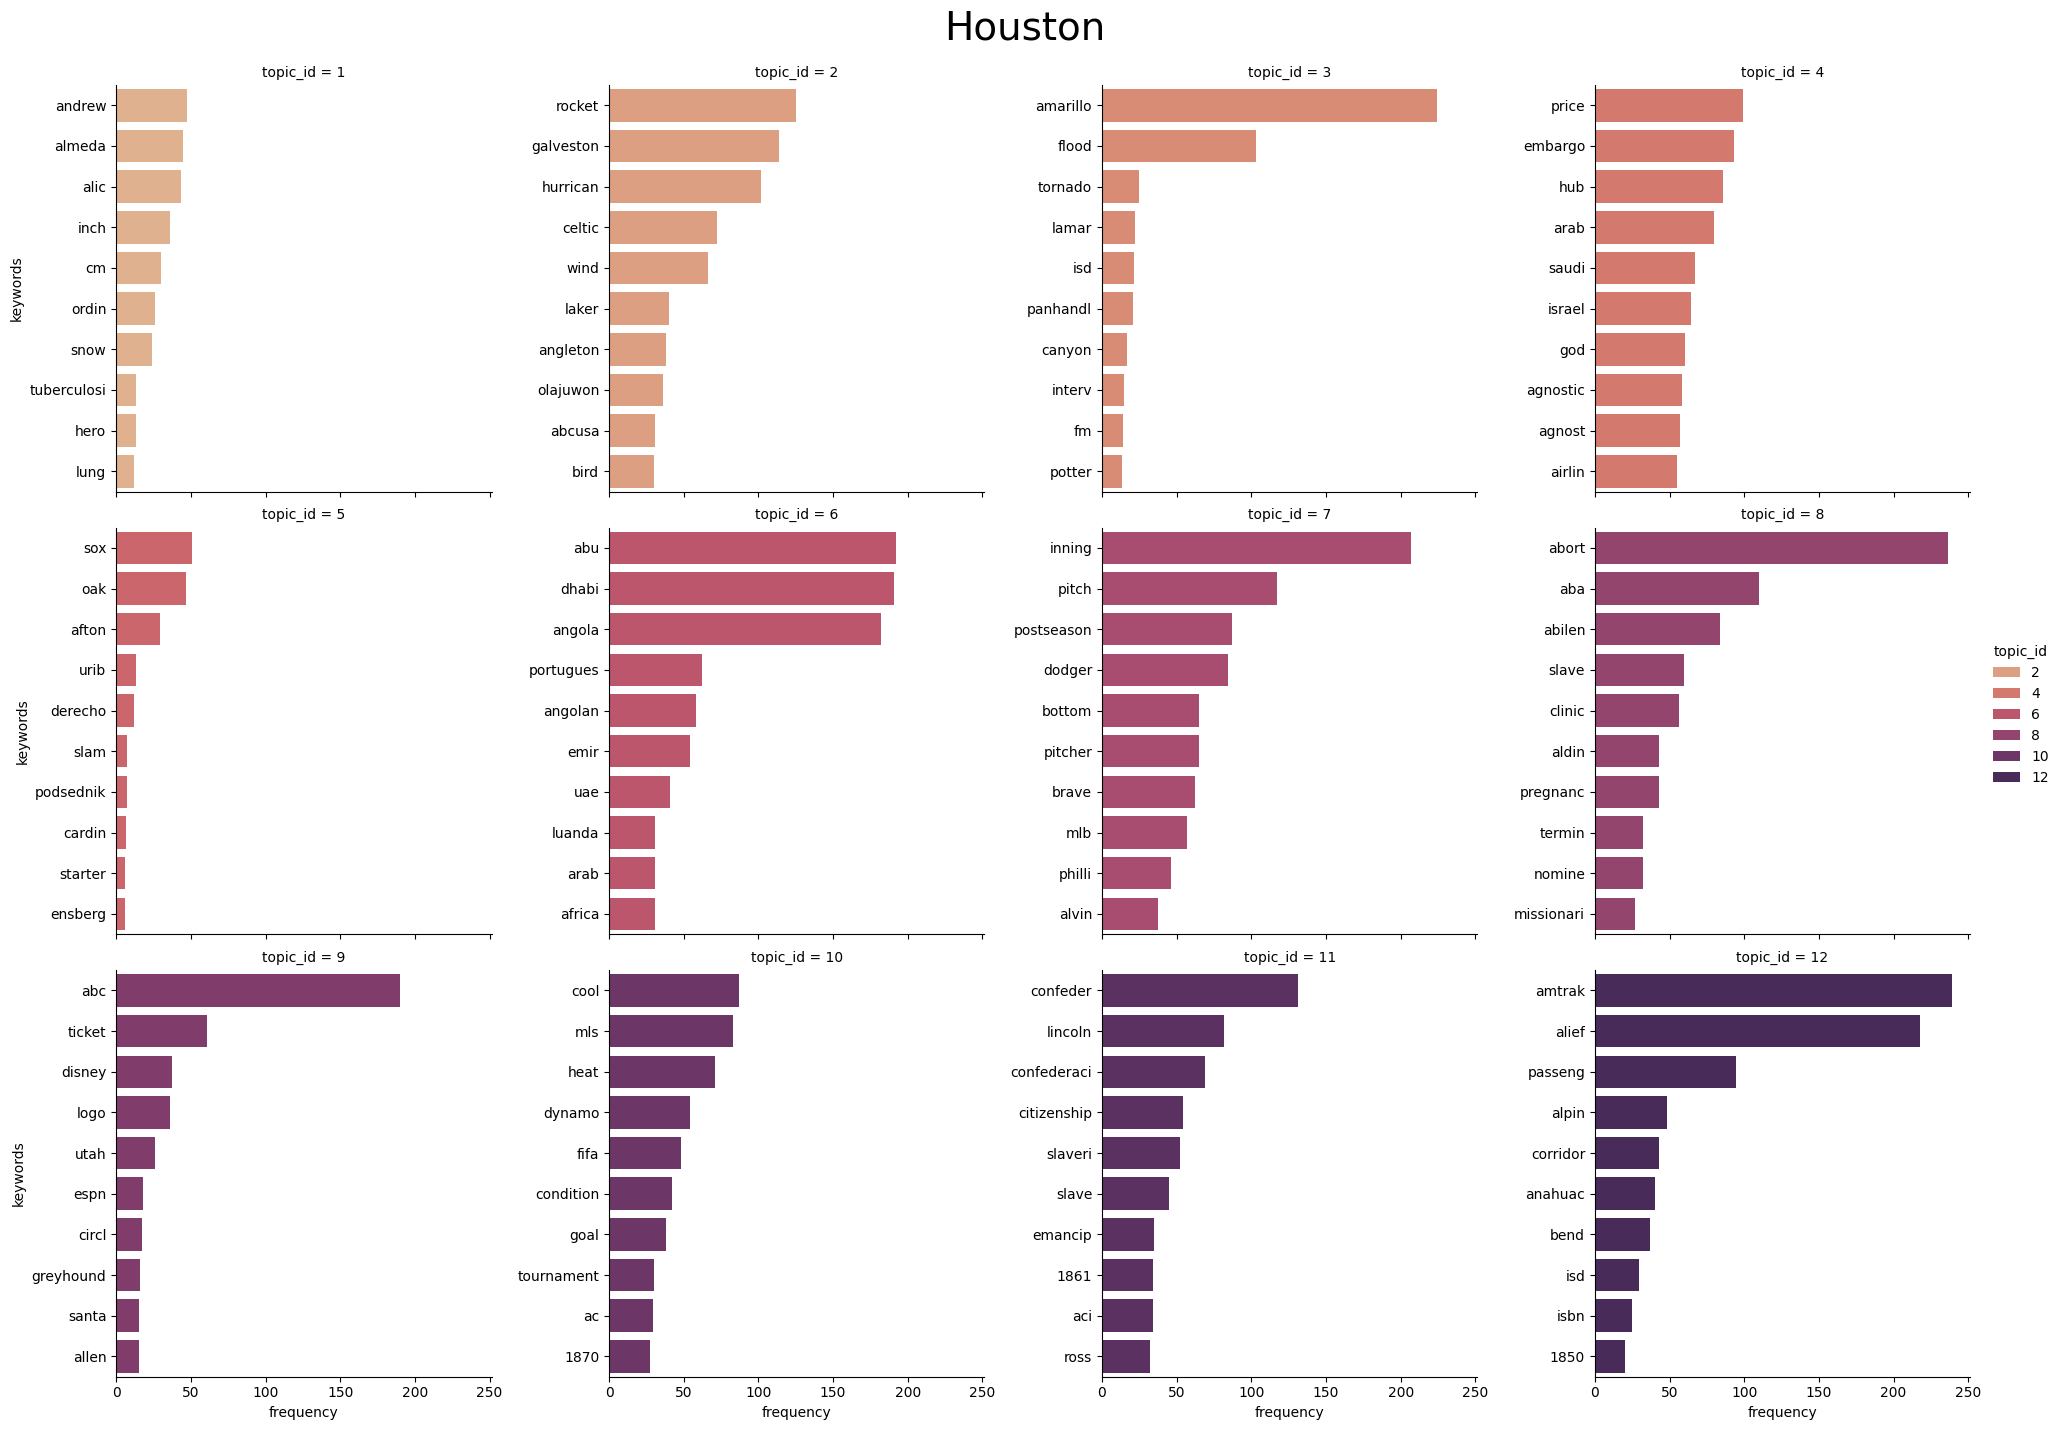

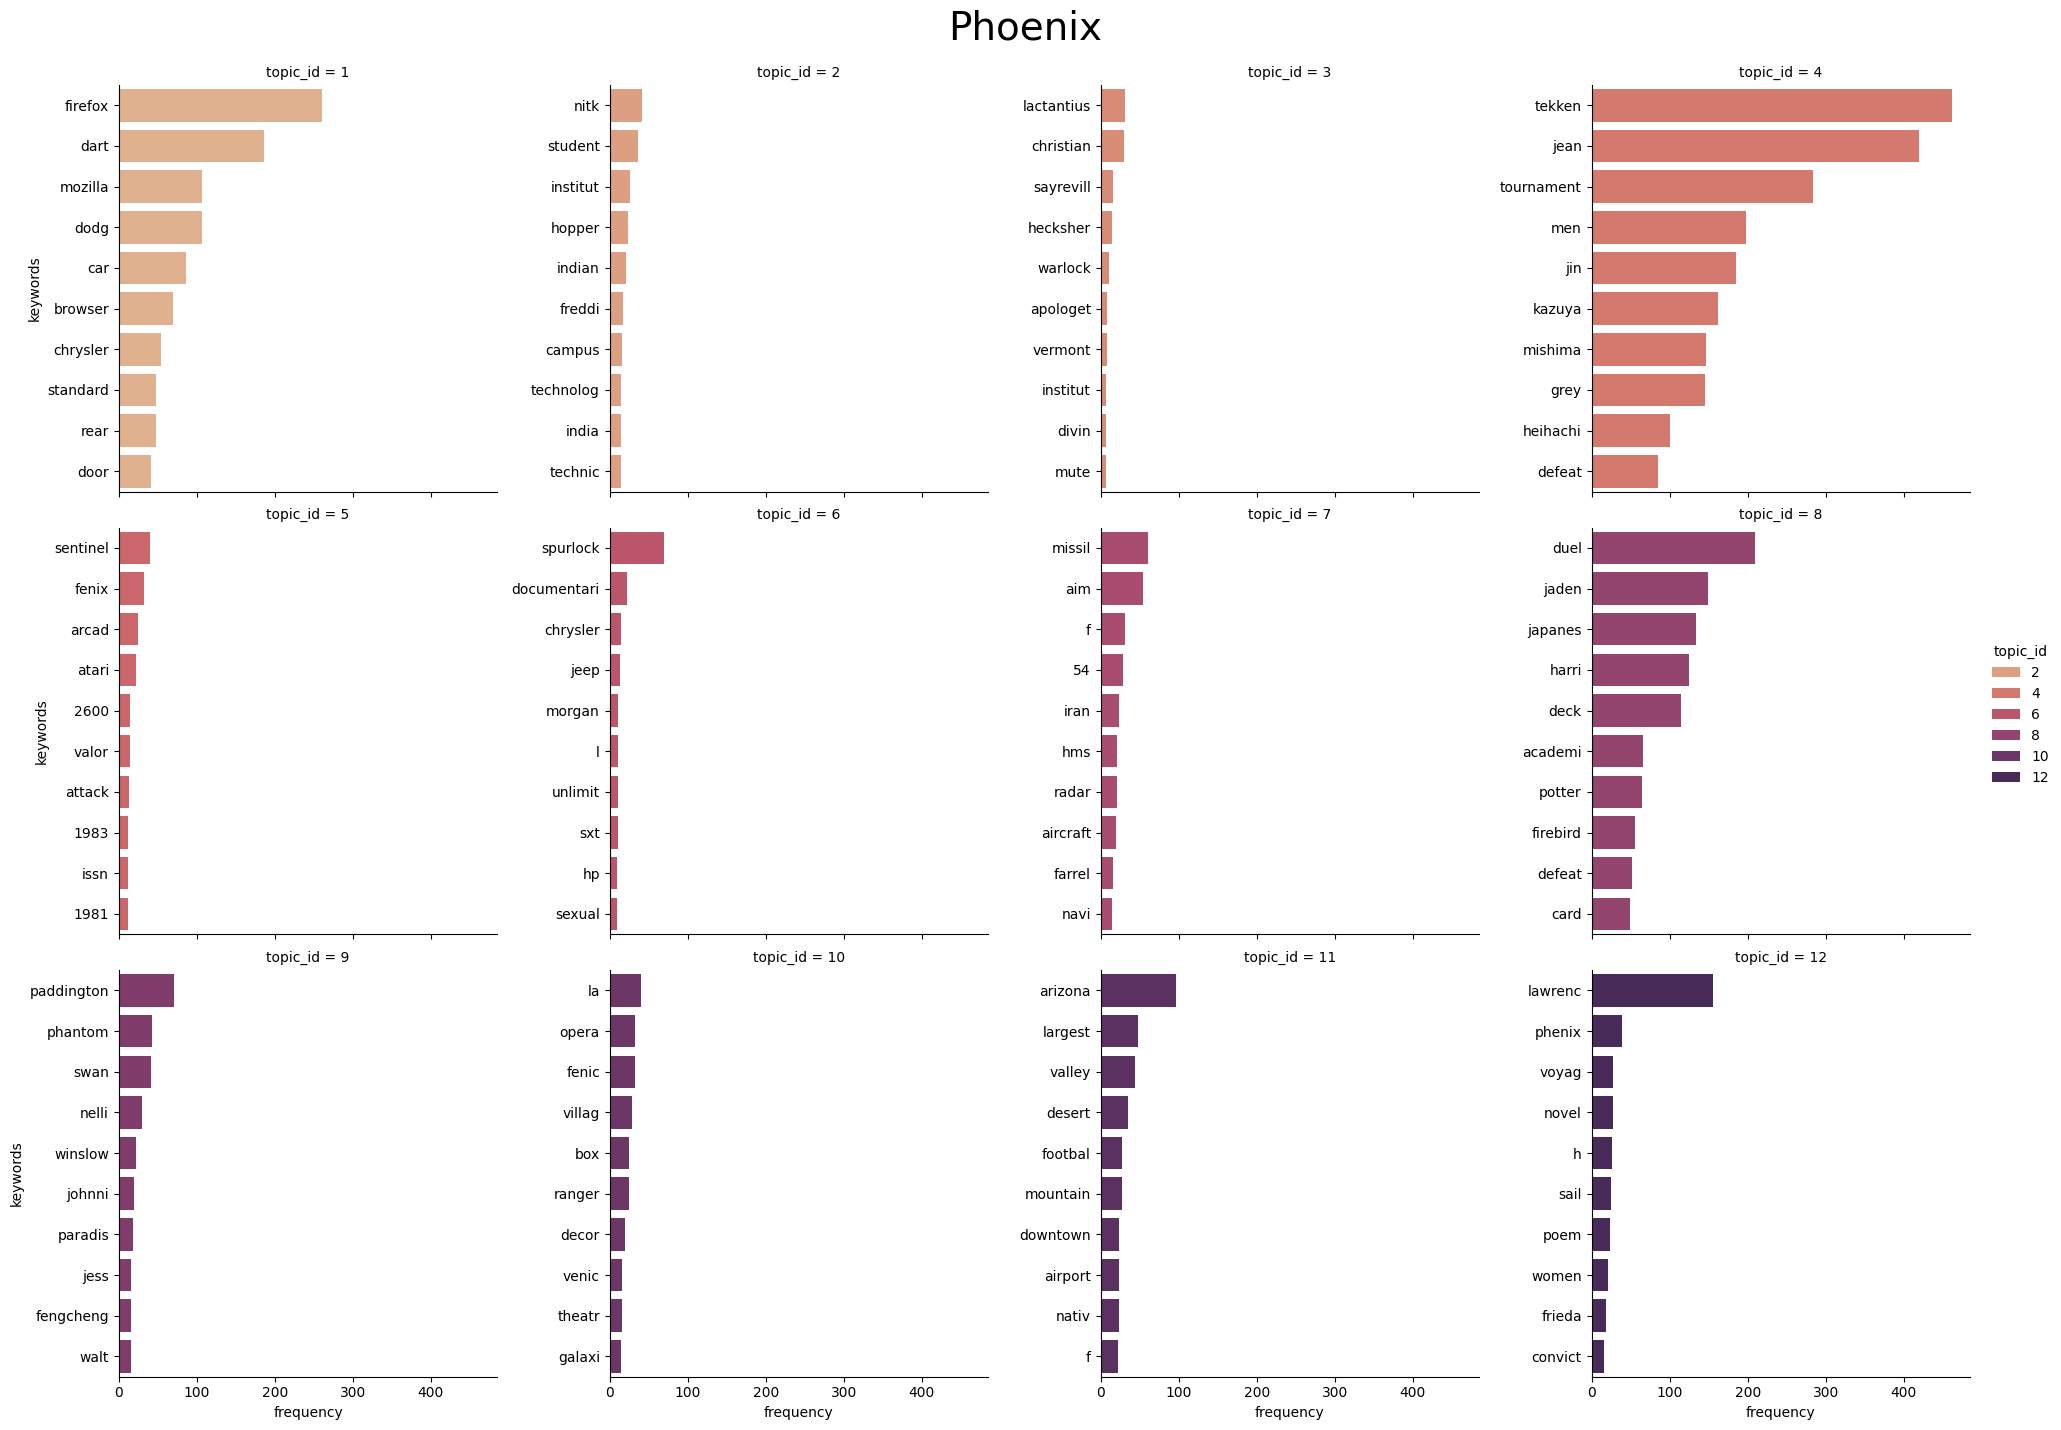

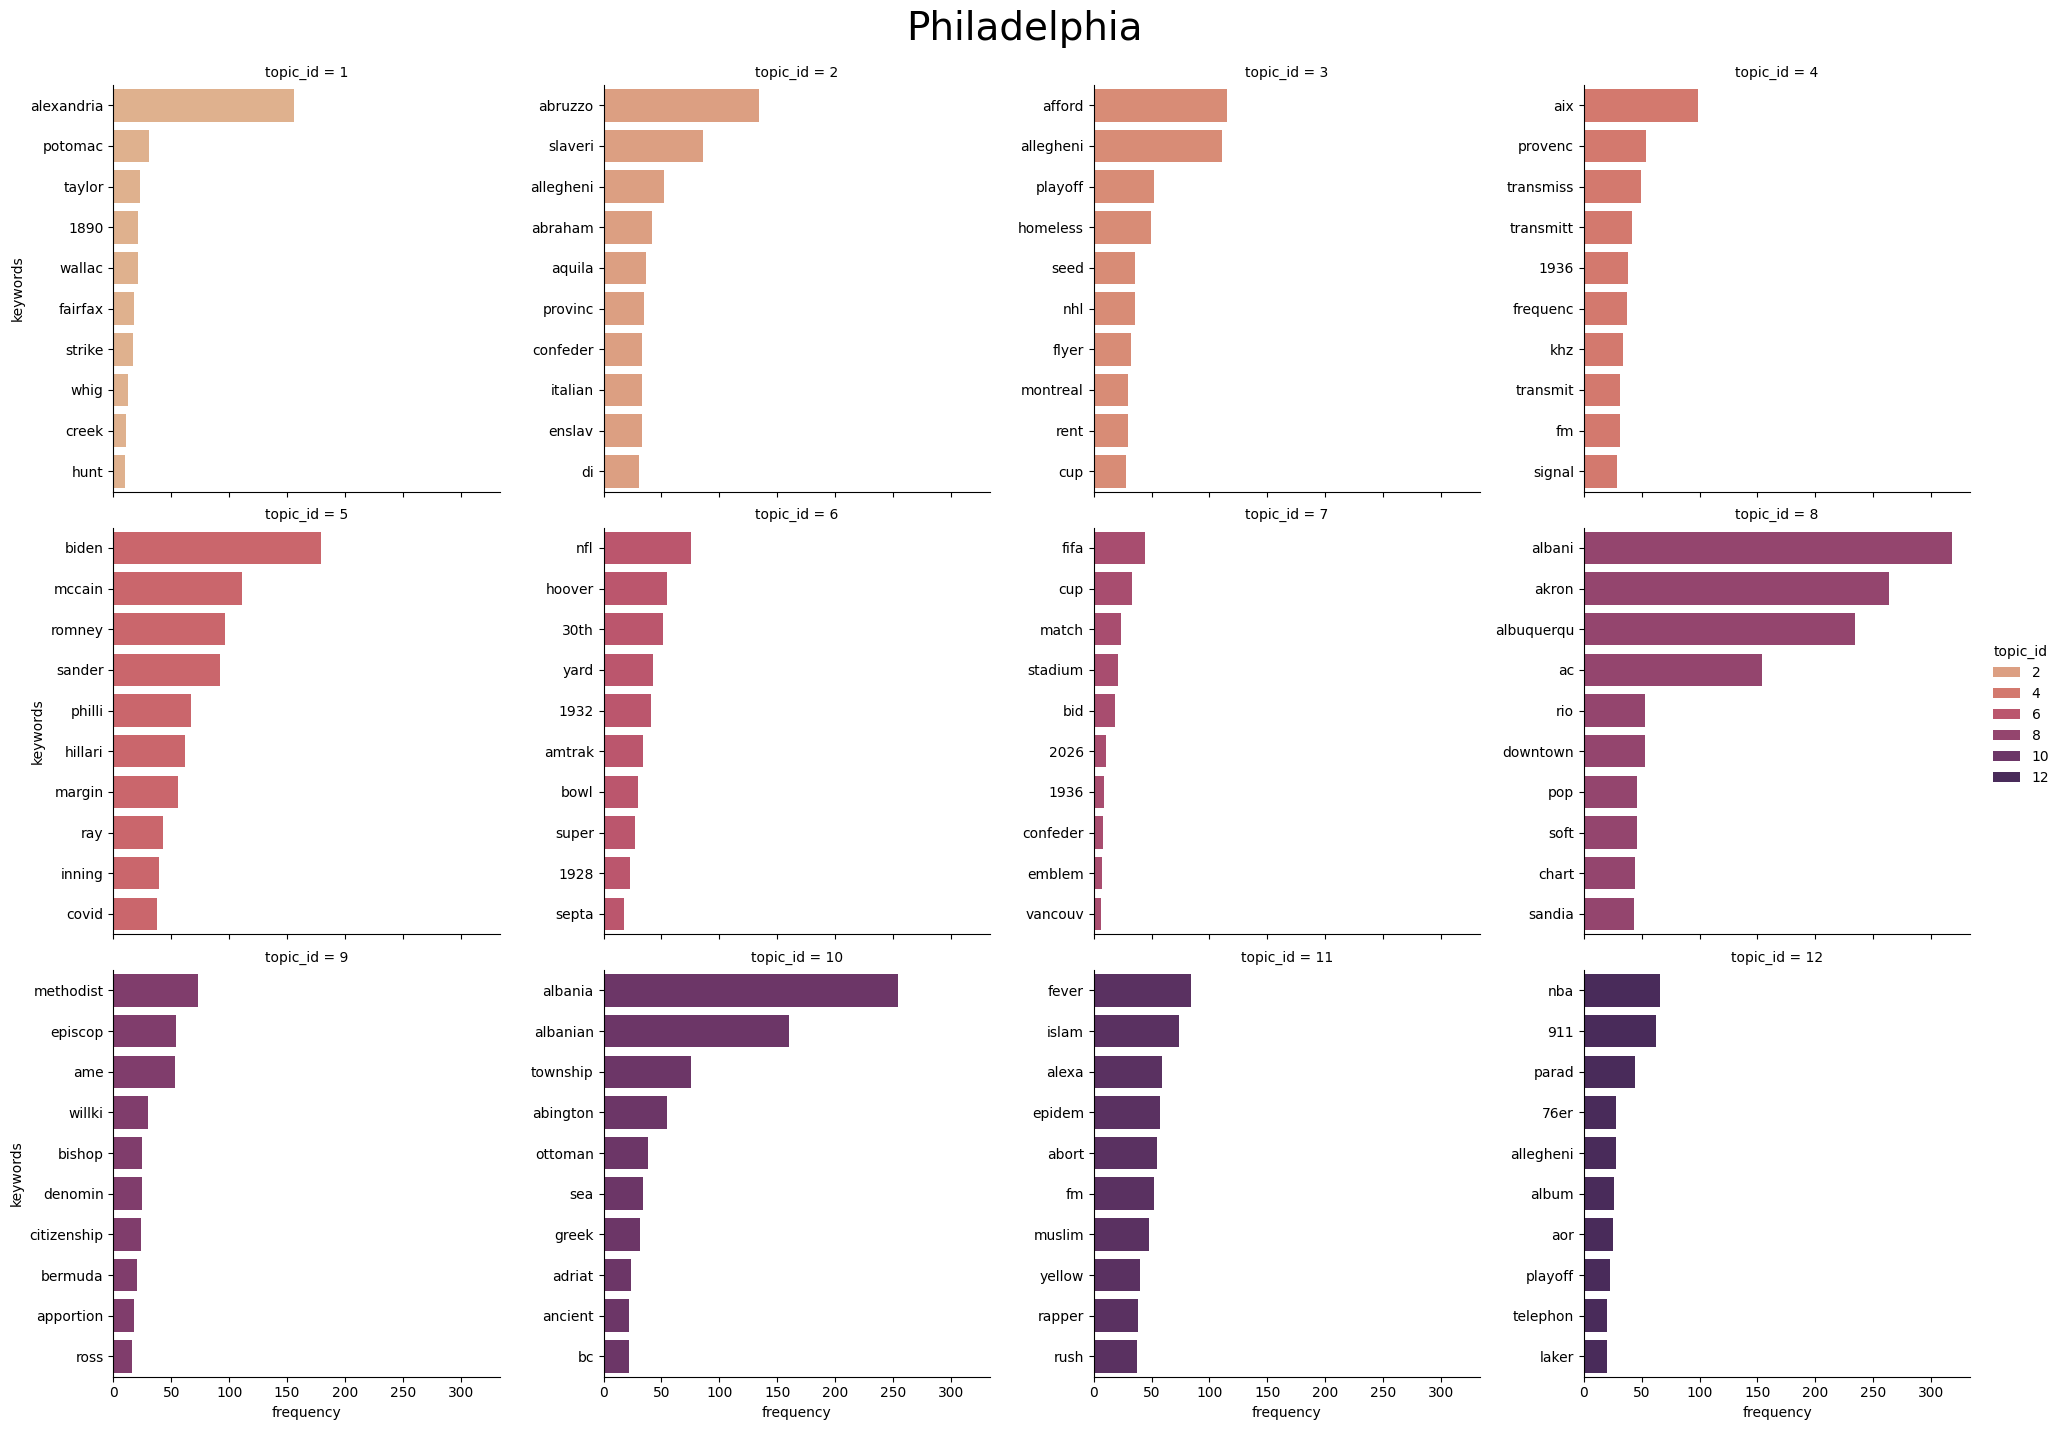

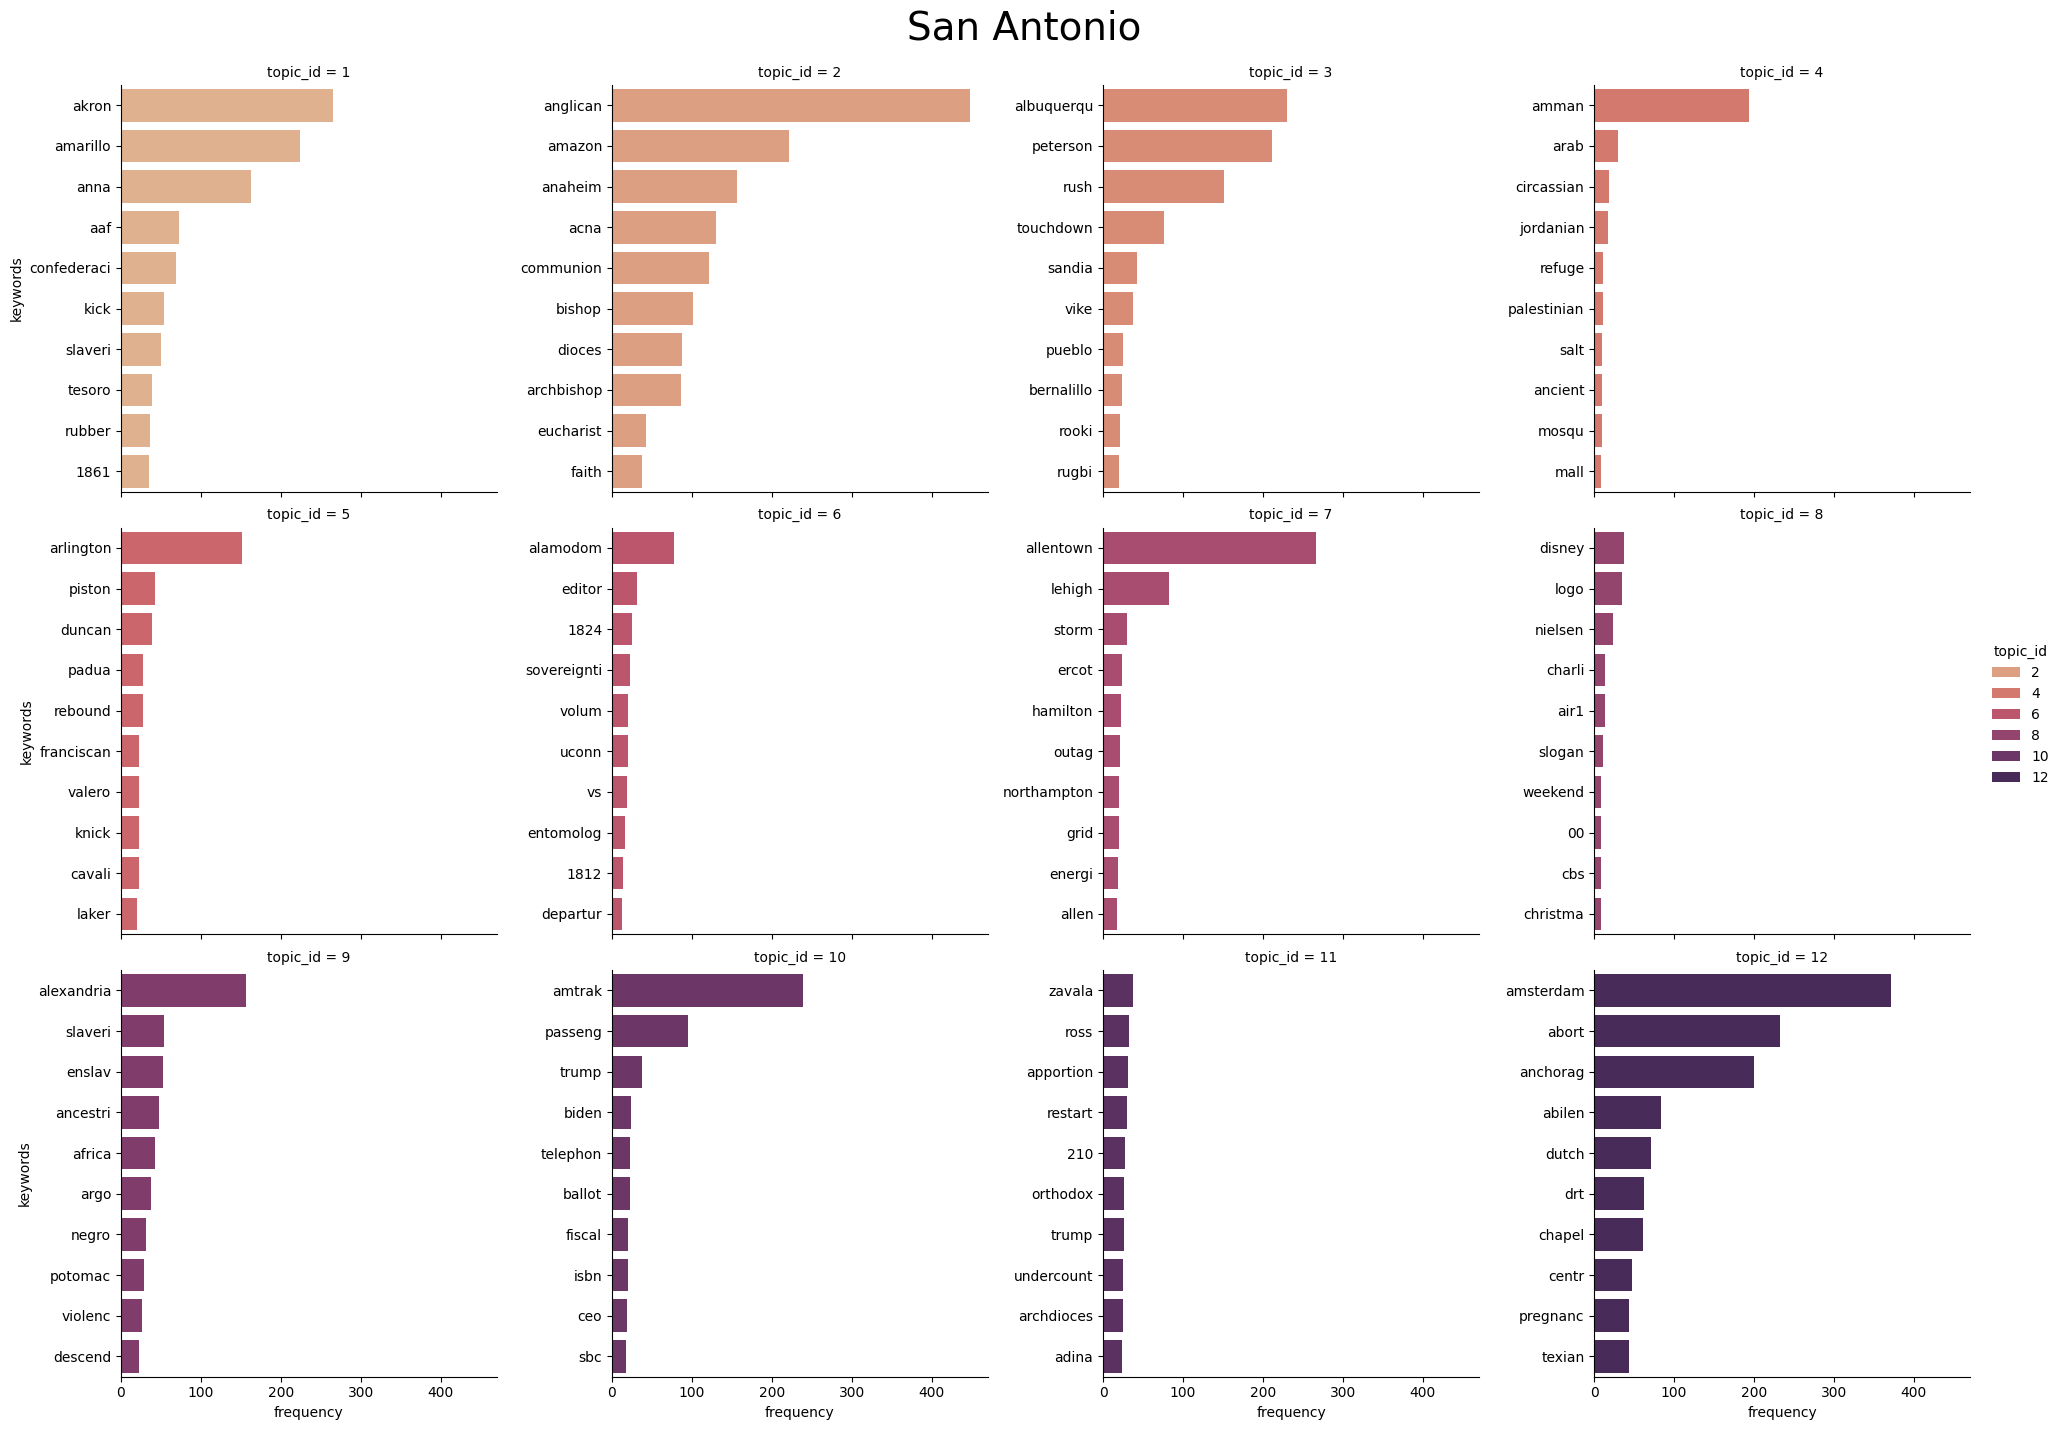

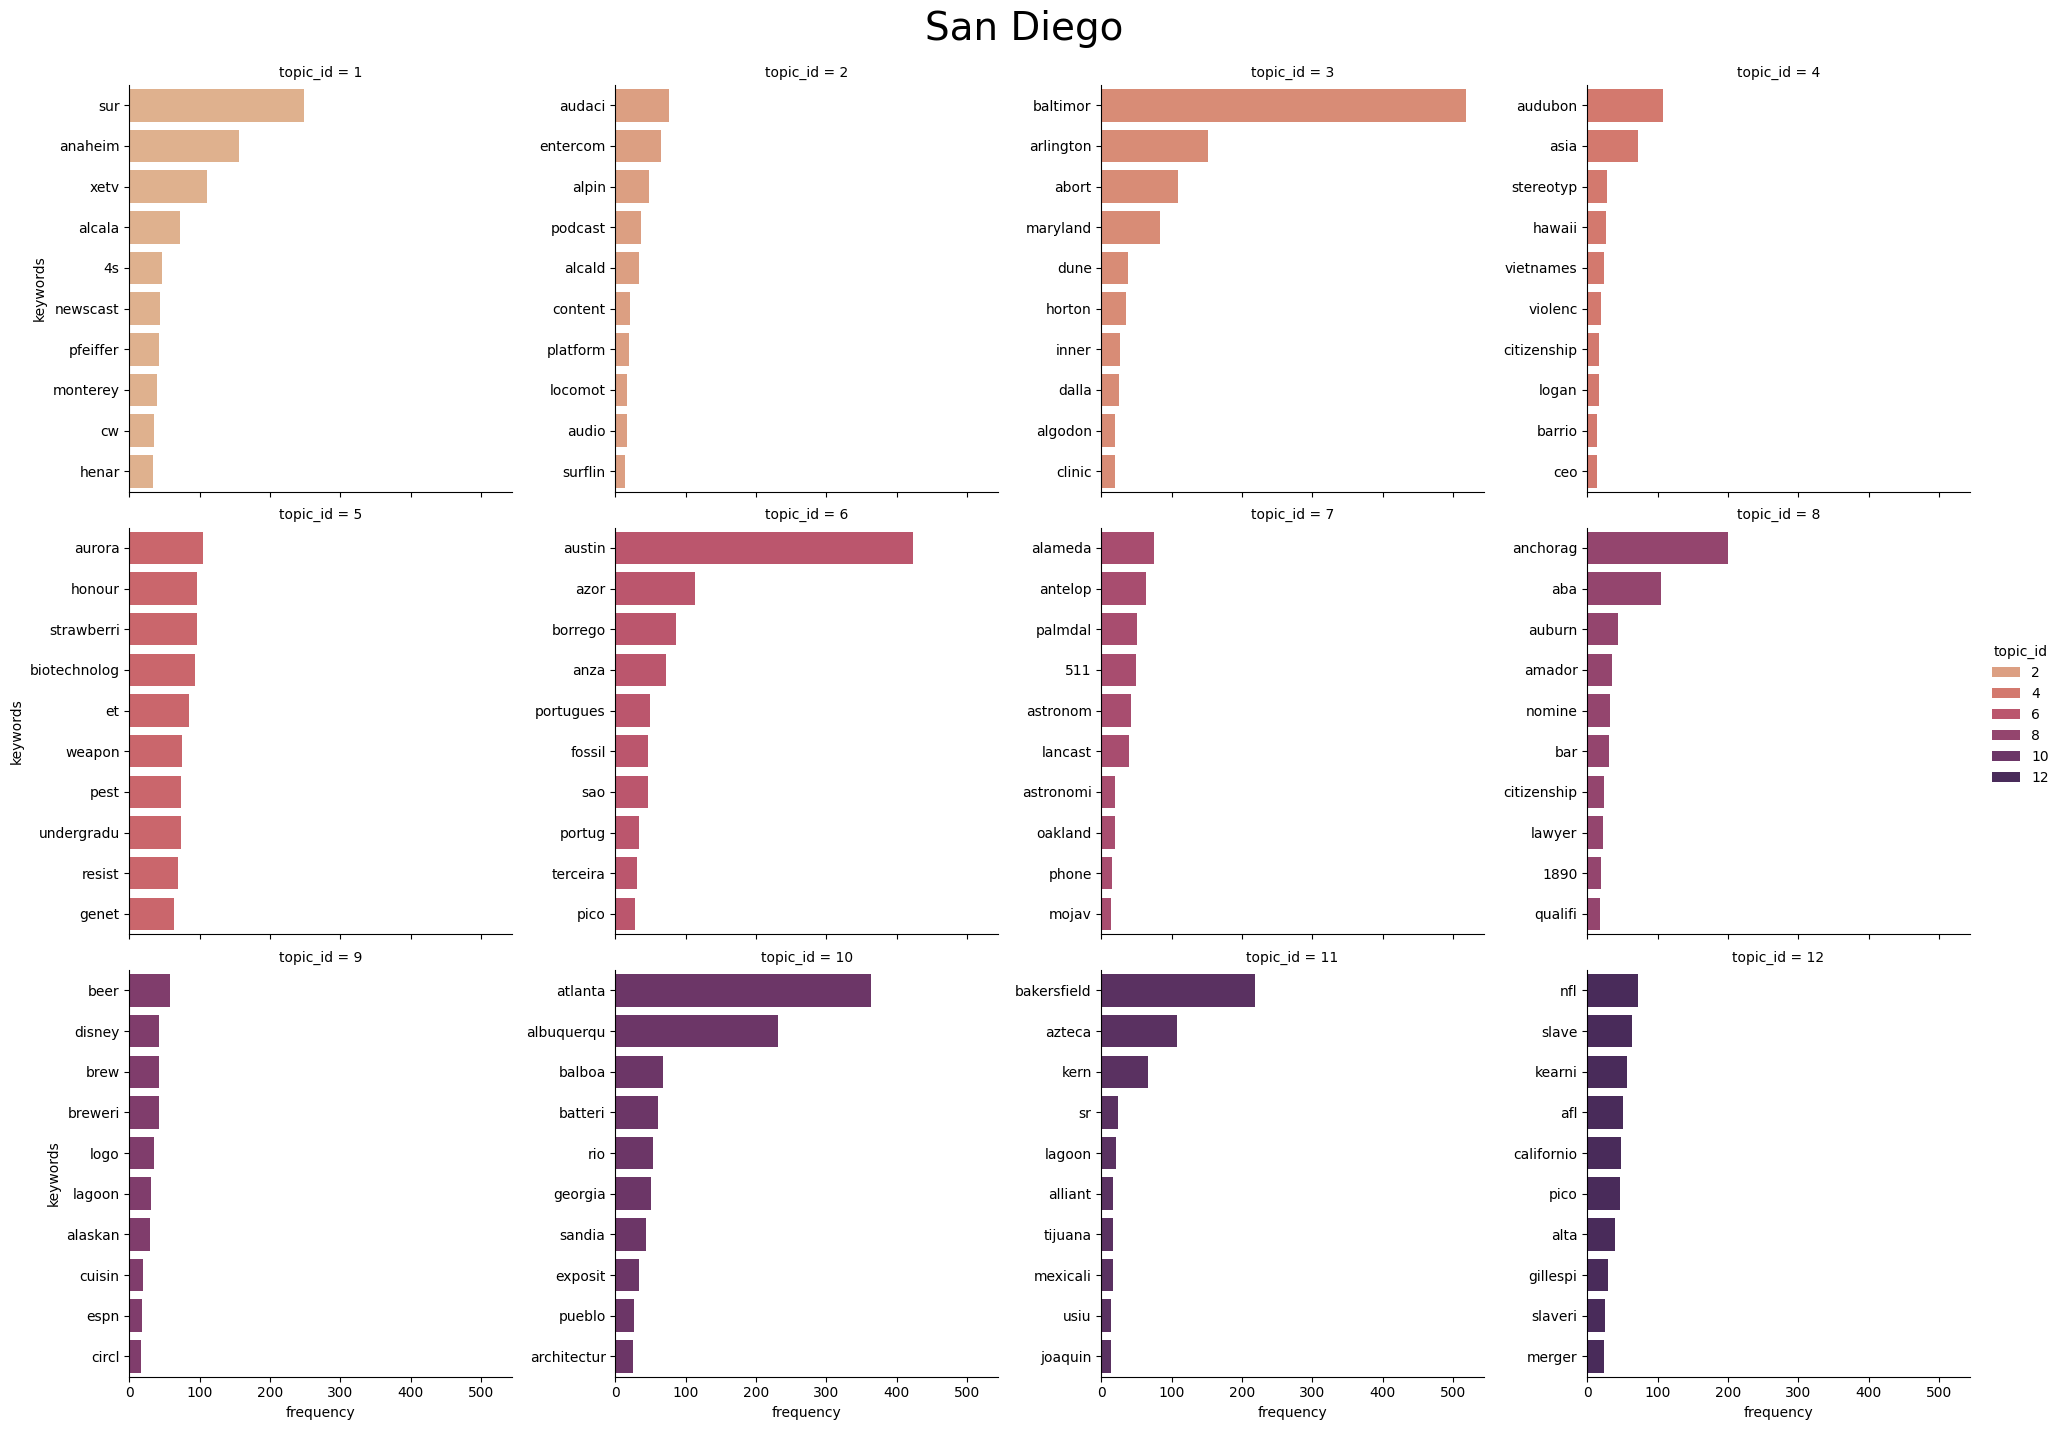

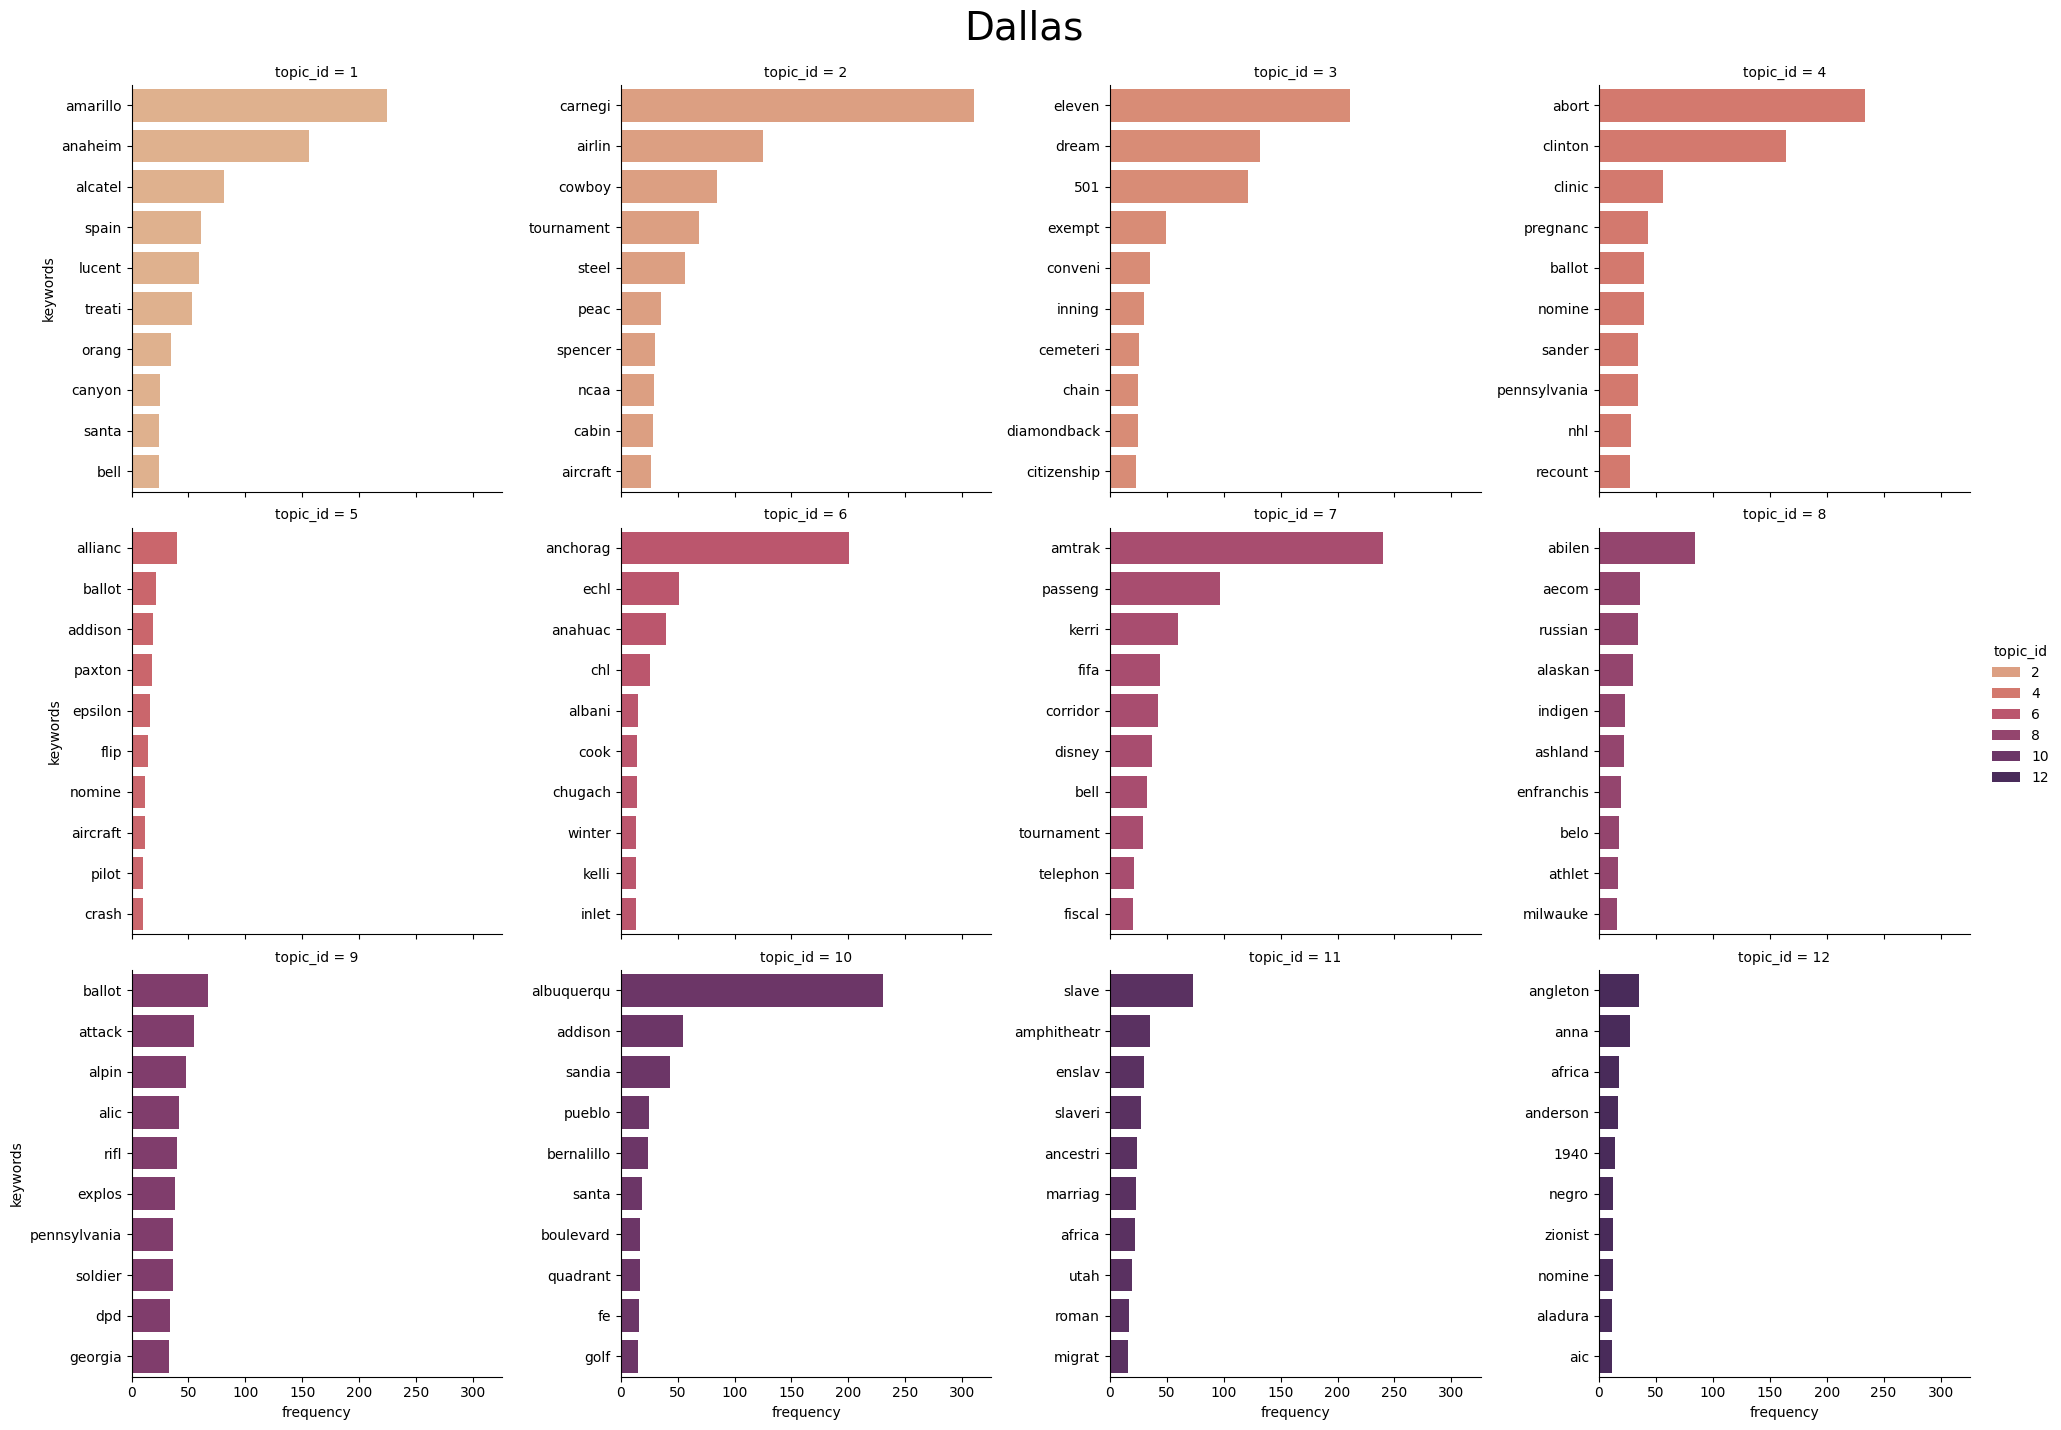

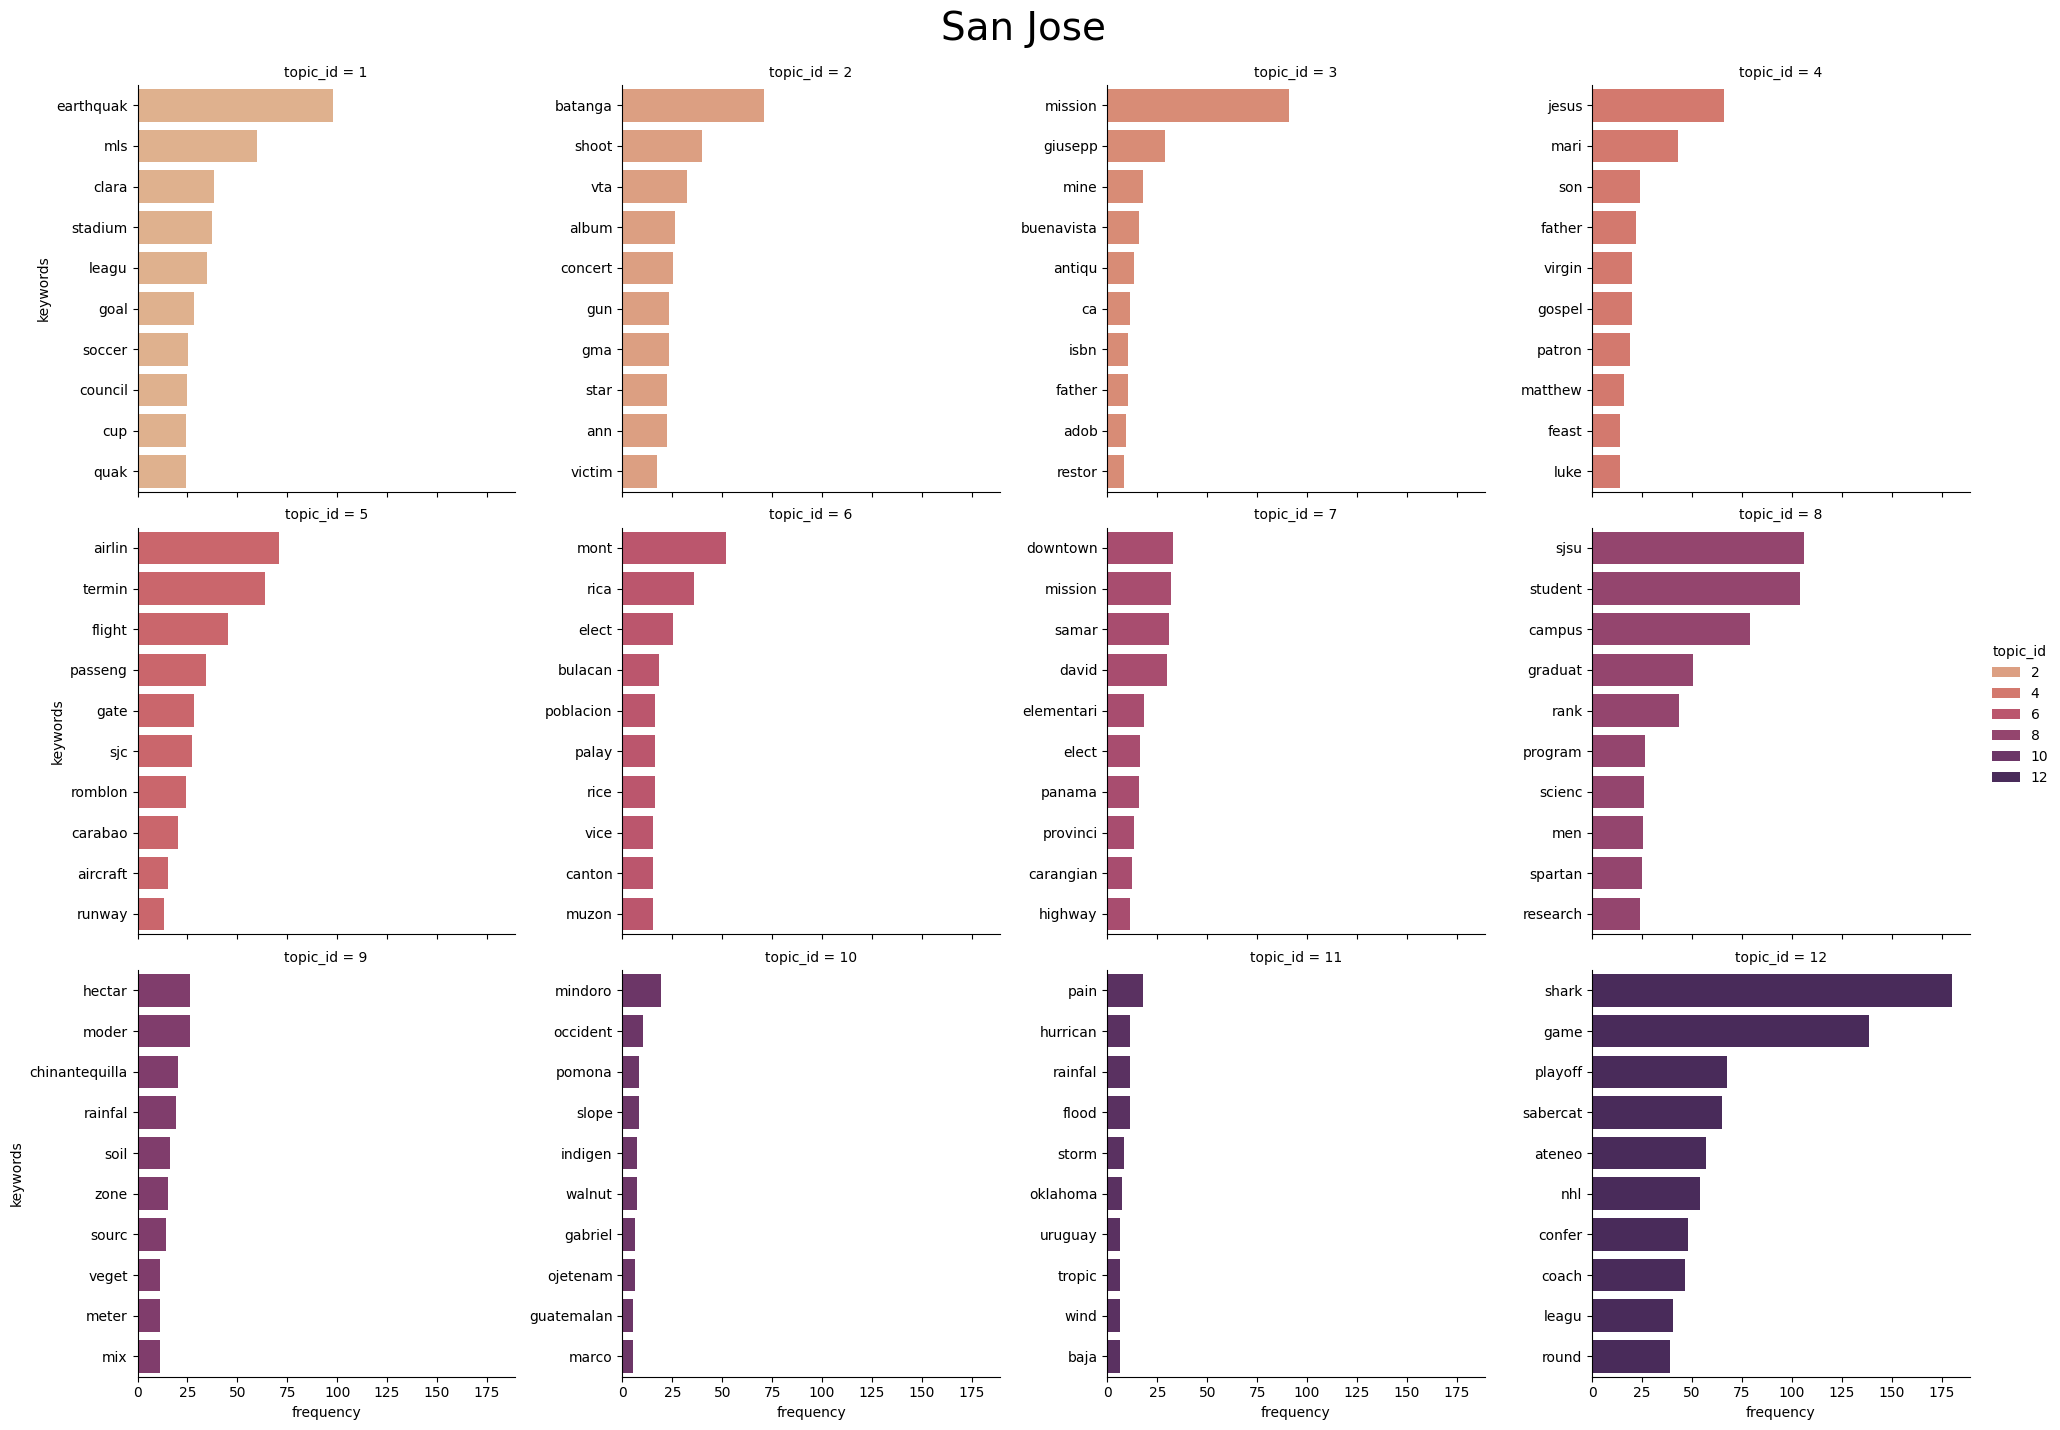

In [99]:
for i, city in enumerate(city_dfs):
    bag_of_words, features = prepare_text(city)
    lda = apply_model(12, bag_of_words)
    visualize_model(10, features, lda, city_titles[i])